# Optimizing Model

**Note:** Grid Search with Hyperparameter Tuning with the HParams Dashboard is presented in the previous section.

## Optimizer Algorithms and Learning Rate

### Gradient descent vs Adaptive

We already get good fit by using Adam algorithms which belongs to family of `Adaptive` algorithms.

How about `Stochastic gradient descent` (SGD) which belongs to family of `Gradient descent optimizers`?

`SGD` is an improved version of batch gradient descent. Many people prefer `SGD` as the optimizer, because it can bring to better model if `learning rate` and `schedule` are fine tuned.

The problem of SGD is that the updates are frequent and with a high variance. A solution to this problem is to slowly decrease the learning rate value. [Link](https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e)  

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.losses import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import SGD

# Import this module's functions
from functions import (
    SuperHighVariationScaler,
    early_stopper,
    map_num_to_string,
    map_string_to_num,
    sparse_array,
)

## Import data

In [16]:
file_name_all_data = "data/_nanocomposite_data.csv"
all_data = pd.read_csv(file_name_all_data, index_col=None, header=0)
# Drop columns which are not used for now
all_data_clean = all_data.drop(
    ["polymer_p2", "ratio_1_2", "filler_2", "wt_l2", "owner", "foaming"],
    axis=1,
)
all_data_clean = map_string_to_num(all_data_clean)

## Prepare Dataset for TensorFlow

### Scaling X and Y data
X data might not need scaling as the range of values is not high.

In [17]:
X_scaler = MinMaxScaler(feature_range=(0, 1))
Y_scaler = SuperHighVariationScaler() 

### Splitting data to training and testing sets

In [18]:
training_data, testing_data = train_test_split(all_data_clean, test_size=0.2, random_state=25)

In [19]:
# Split into input features (X) and output labels (Y) variables
X_training = training_data.drop('conductivity', axis=1).values
Y_training = training_data[['conductivity']].values

# Pull out columns for X (data to train with) and Y (value to predict)
X_testing = testing_data.drop('conductivity', axis=1).values
Y_testing = testing_data[['conductivity']].values

# Scale both the training inputs and outputs
X_scaled_training = X_scaler.fit_transform(X_training)
Y_scaled_training = Y_scaler.fit_transform(Y_training)

# The training and test data are scaled with the same scaler.
X_scaled_testing = X_scaler.transform(X_testing)
Y_scaled_testing = Y_scaler.transform(Y_testing)

# Model build with `SGD` optimizer

In [20]:
# Create model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(256, activation="relu", input_dim=3))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(8, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="linear"))

# tf.keras.optimizers.schedules.InverseTimeDecay => Does not work well
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.00001, decay_steps=100000
)

model.compile(
    loss=MeanAbsolutePercentageError(),
    optimizer=SGD(learning_rate=lr_schedule),
)

In [21]:
history = model.fit(
    X_scaled_training,
    Y_scaled_training,
    validation_data=(X_scaled_testing, Y_scaled_testing),
    epochs=1000,
    batch_size=64,
    verbose=0,
    callbacks=[
        early_stopper(
            monitor="val_loss",
            patience=100,
            verbose=0,
        )
    ],
)

## Plotting predicting vs testing data

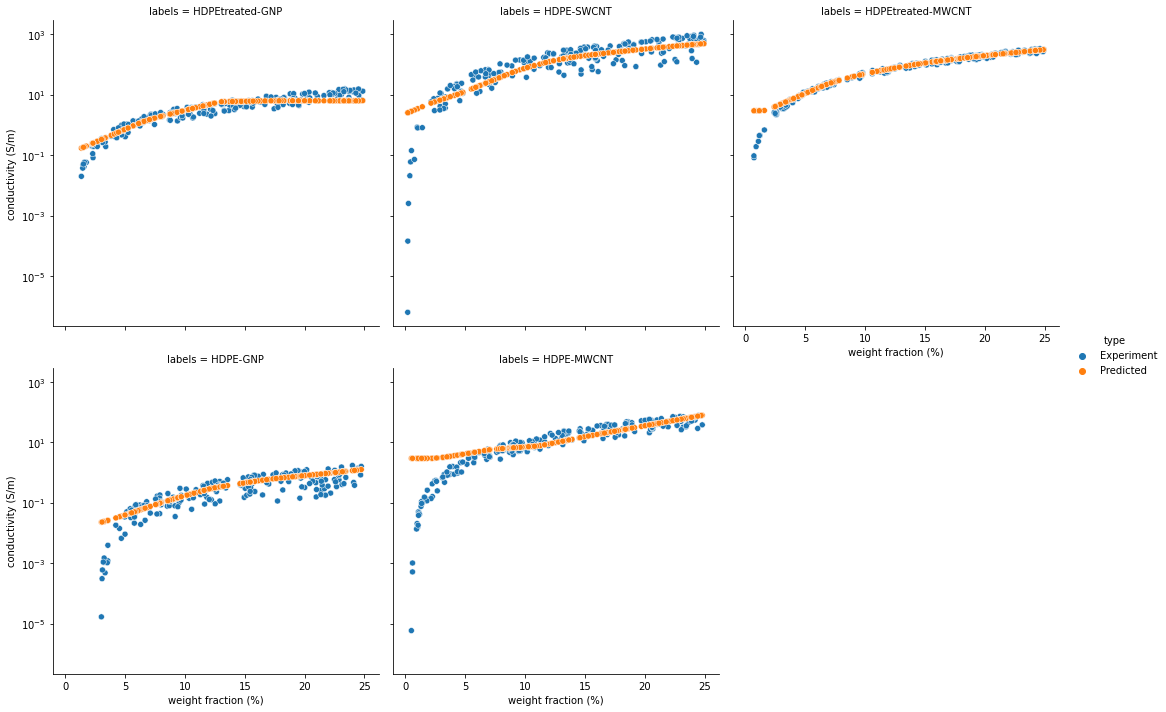

In [22]:
# Calculate predictions
predicted_values = model.predict(X_scaled_testing)
predicted_values = Y_scaler.inverse_transform(predicted_values)

complete_data = testing_data.copy()
complete_data = map_num_to_string(complete_data)

complete_data["labels"] = (
    complete_data["polymer_1"] + "-" + complete_data["filler_1"]
)
complete_data["type"] = "Experiment"
other_data = complete_data.copy()
other_data["type"] = "Predicted"
other_data["conductivity"] = predicted_values

complete_data = pd.concat([complete_data, other_data], ignore_index=True)

g = sns.relplot(
    data=complete_data,
    x="wt_l1",
    y="conductivity",
    hue="type",
    col="labels",
    kind="scatter",
    col_wrap=3,
)
g.set_xlabels("weight fraction (%)")
g.set_ylabels("conductivity (S/m)")
g.set(yscale="log")


# Extrapolation: Estimate higher wt (>25%)

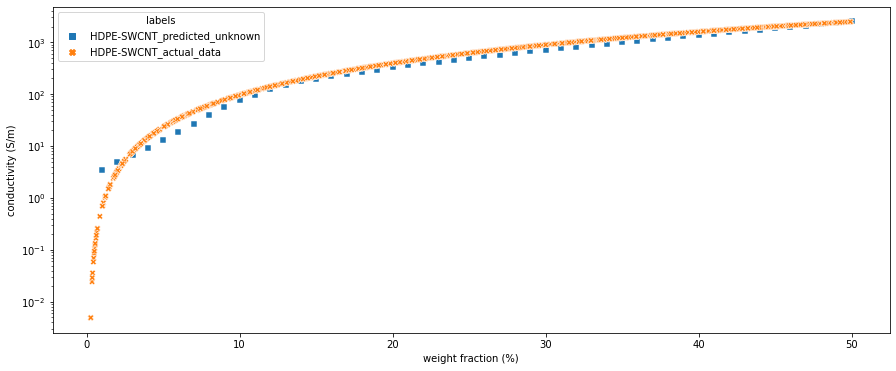

In [23]:
file_name_unknown_data_7 = "data-evaluation/HDPE_SWCNT_data-set-7.csv"
unknown_data_7 = pd.read_csv(
    file_name_unknown_data_7, index_col=None, header=0
)
unknown_data_7.drop(
    ["polymer_p2", "ratio_1_2", "filler_2", "wt_l2", "owner", "foaming"],
    axis=1,
    inplace=True,
)
unknowndata7_clean = unknown_data_7.copy()
unknowndata7_clean = map_string_to_num(unknowndata7_clean)
# Pull out columns for X (data to train with) and Y (value to predict)
X_unknown_data_7 = unknowndata7_clean.drop("conductivity", axis=1).values
X_scaled_unknowndata7 = X_scaler.transform(X_unknown_data_7)
# Calculate predictions
predicted_unknown_data_7 = model.predict(X_scaled_unknowndata7)
predicted_unknown_data_7 = Y_scaler.inverse_transform(predicted_unknown_data_7)
complete_data = unknown_data_7.copy()
complete_data["labels"] = (
    complete_data["polymer_1"]
    + "-"
    + complete_data["filler_1"]
    + "_predicted_unknown"
)
complete_data["conductivity"] = predicted_unknown_data_7

file_name_data_8 = "data-evaluation/HDPE_SWCNT_data-set-8.csv"
data8 = pd.read_csv(file_name_data_8, index_col=None, header=0)
data8["labels"] = data8["polymer_1"] + "-" + data8["filler_1"] + "_actual_data"

complete_data = pd.concat([complete_data, data8], ignore_index=True)

labels = complete_data["labels"].unique()  # get 2 labels in data set.

fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
plt.xlabel("weight fraction (%)")
plt.ylabel("conductivity (S/m)")
plt.yscale("log")
g = sns.scatterplot(
    data=complete_data,
    x="wt_l1",
    y="conductivity",
    hue="labels",
    style="labels",
    ax=ax,
    markers={labels[0]: "s", labels[1]: "X"},
)
plt.show()

# Conclusion

## Alternative optimizers

Although there is no large difference, these alternative optimizers and configuration are good to considers

### `SGD`
```python
model.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(), 
                      optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, decay=1e-6) )
```
### `Adagrad`
```python
model.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(),
                      optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01,initial_accumulator_value=1.0))
```
### `Adadelta`
```python
model.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(),
                      optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0))
```


## Learning schedules

To controll learning schedules, we can use `LearningRateSchedule` such as 

### In cases of  `SGD`  these are best fit

```python
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay( 
                initial_learning_rate = 0.00001, decay_steps=1000, decay_rate=0.99, staircase=True)

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
                initial_learning_rate = 0.00001, decay_steps = 100000)
```

## Loss function

Because we need to carefully consider both extremely low and extremely high values of electrical conductivity, we need to calculate the __relative differences__ between `true value` and `predict value`. We could use their magnitude orders (by taking logarithm of the values). 

`tf.keras.losses.MeanAbsolutePercentageError` Formula:
```python
loss = 100 * abs((y_true - y_pred) / y_true)
```

There are a few choices available which work well for our problem. 